In [2]:
import jerel
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from astropy.table import Table
import random
from marvin.tools import Maps


[INFO]: No release version set. Setting default to DR15


In [4]:
from astroquery.skyview import SkyView
import matplotlib.pyplot as plt
from astropy.table import Table
import numpy as np

control = Table.read('./stat/control_stat_805.fits')


In [5]:
control['objra'][0]

140.192444114

In [31]:
num = 80
image_list = SkyView.get_images(position=str(control['objra'][num])+','+str(control['objdec'][num]),
                                survey='SDSSg',
                                pixels='200')
                                
image = image_list[0][0].data

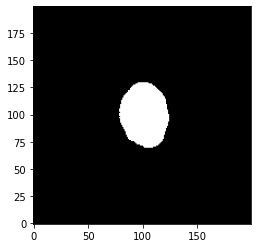

In [32]:
import photutils
import scipy.ndimage as ndi
import statmorph
threshold = photutils.detect_threshold(image, 3)
npixels = 10  # minimum number of connected pixels
segm = photutils.detect_sources(image, threshold, npixels)
# Keep only the largest segment
label = np.argmax(segm.areas) + 1
segmap = segm.data == label
segmap_float = ndi.uniform_filter(np.float64(segmap), size=10)
segmap = segmap_float > 0.5
plt.imshow(segmap, origin='lower', cmap='gray')

[WARNING]: invalid value encountered in log (RuntimeWarning)


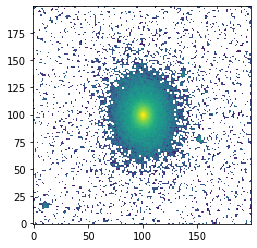

In [33]:
plt.imshow(np.log(image),origin='lower')

In [18]:
source_morphs = statmorph.source_morphology(
    image, segmap,gain=10)
morph = source_morphs[0]
print('r20 =', morph.r20)
print('r80 =', morph.r80)
print('Gini =', morph.gini)
print('con =', morph.concentration)

r20 = 6.171350389931648
r80 = 39.534829607368565
Gini = 0.5949835413523145
con = 4.032998331808927


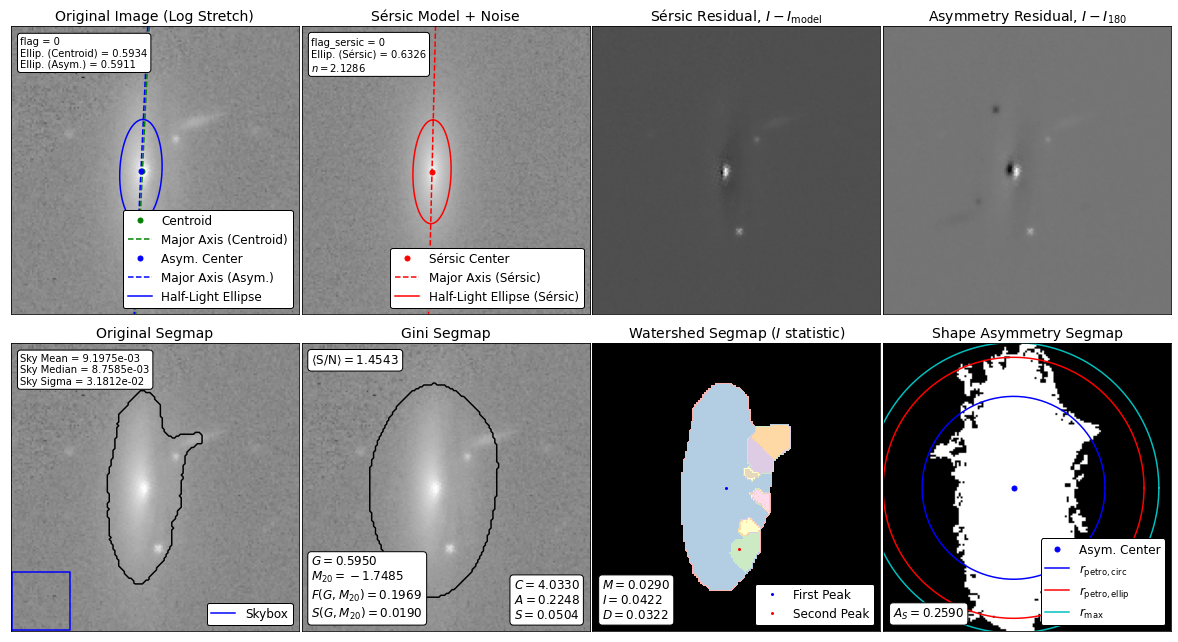

In [17]:
from statmorph.utils.image_diagnostics import make_figure
fig = make_figure(morph)

In [11]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

from marvin import config

config.setRelease('DR16')
config.setDR('DR16')

from marvin.tools.image import Image
from marvin.tools import Maps
from marvin.tools import Cube

from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
drpall_path = config.drpall


def get_dl(red_shift):
    '''
    Calculate the luminosity distance with a given redshift. In cm unit.
    '''
    dl = cosmo.luminosity_distance(red_shift).to_value(unit='cm')
    return dl

def my_ha(plateifu, min_snr=3, max_radii=1.5):
    '''
    get my own Ha emission map in numpy.ma.array instance within minimum SNR and maximum effective readius. 
    Then convert it to Luminosity (erg /s /arcsec^2)
    '''
    maps = Maps(plateifu=plateifu)
    ha = maps.emline_gflux_ha_6564
    er = maps.spx_ellcoo_r_re
    z = maps.nsa['z']
    drpall_mask = ha.pixmask.get_mask(['DONOTUSE', 'UNRELIABLE', 'NOCOV'],
                                      dtype=bool)
    snr_mask = (ha.snr < min_snr) + drpall_mask
    radii_mask = (er.value > max_radii) + drpall_mask
    my_ha = np.ma.array(ha.data, mask=snr_mask + radii_mask)
    dl = get_dl(z)
    masked_lumi = my_ha * 1e-17 * 4 * math.pi * (dl**2) / 0.25
    return masked_lumi

def my_hb(plateifu, min_snr=3, max_radii=1.5):
    '''
    get my own Ha emission map in numpy.ma.array instance within minimum SNR and maximum effective readius. 
    Then convert it to Luminosity (erg /s /arcsec^2)
    '''
    maps = Maps(plateifu=plateifu)
    hb = maps.emline_gflux_hb_4862
    er = maps.spx_ellcoo_r_re
    z = maps.nsa['z']
    drpall_mask = hb.pixmask.get_mask(['DONOTUSE', 'UNRELIABLE', 'NOCOV'],
                                      dtype=bool)
    snr_mask = (hb.snr < min_snr) + drpall_mask
    radii_mask = (er.value > max_radii) + drpall_mask
    my_hb = np.ma.array(hb.data, mask=snr_mask + radii_mask)
    dl = get_dl(z)
    masked_lumi = my_hb * 1e-17 * 4 * math.pi * (dl**2) / 0.25
    return masked_lumi

[WARNING]: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead (DeprecationWarning)
[WARNING]: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead (DeprecationWarning)


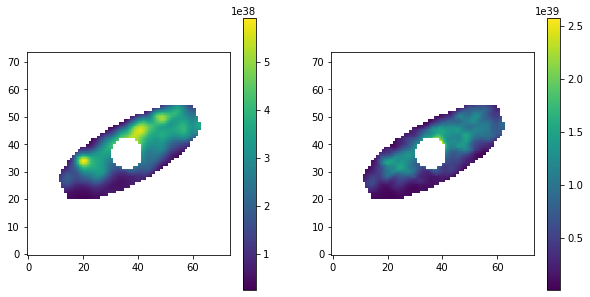

In [40]:
plateifu = '8625-12702'
ha = my_ha(plateifu)
hb = my_hb(plateifu)
ext_factor=((ha/hb)/2.8)**2.36
fig,axs = plt.subplots(1,2)
fig.set_size_inches(w=10,h=5)
im1= axs[0].imshow(ha,origin='lower')
im2 =axs[1].imshow(ha*ext_factor,origin='lower')
fig.colorbar(im1,ax=axs[0])
fig.colorbar(im2,ax=axs[1])

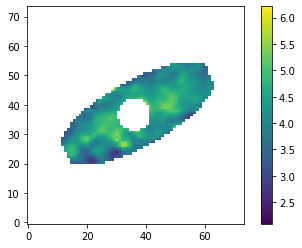

In [39]:
plt.imshow(ha/hb,origin='lower')
plt.colorbar()